# Linear Regression: Engineering & Regularizaion
#### King Count Housing Data
* June 14, 2019
* Flatiron School, NYC (mhtn-ds-042219)

## Project Description
## Import libraries and set up environment

In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 300)



In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

class LinearModeler():

    def __init__(self, data_file=''):
        self.df = None
        self.target = None
        self.features = None
        self.data_file = data_file
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scale = True
        self.model = None
        self.y_train_pred = None
        self.train_mae = None
        self.train_mse = None
        self.train_rmse = None
        self.y_pred = None
        self.test_mae = None
        self.test_rmse = None
        self.target_std = None
        self.results = {}
        self.history = []

    def read_csv(self, data_file=''):
        if data_file != '':
            self.data_file = data_file
        try:
            self.df = pd.read_csv(self.data_file,index_col='id')
            return self.df.shape

        except Exception as e:
            print(e)

    def explore_data(self):
        self.df.shape

        sns.set(style="white")

        # Compute the correlation matrix
        corr = self.df.corr()

        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

    def plot_pairs(self, cols=[]):
        if cols == []:
            cols = self.df.columns

        sns.pairplot(self.df, vars=cols)

    def missing_data(self):
        #missing data
        total = self.df.isnull().sum().sort_values(ascending=False)
        percent = (self.df.isnull().sum()/self.df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data.head(20)

    def set_target_and_features(self, target, features):
        self.target = self.df[target]
        self.features = self.df[features]
        self.base_features = features

    def get_drop_list_corrs(self, threshold=0.95):

        # Create correlation matrix
        # Select upper triangle of correlation matrix
        corr_matrix = self.X_train.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        return [column for column in upper.columns if any(upper[column] > threshold)]

    def get_drop_list_f_test(self, k=10):
        selector = SelectKBest(f_regression, k)
        selector.fit(self.X_train, self.y_train)
        return self.X_train.columns[~selector.get_support()]

    def get_drop_list_rfecv(self):
        ols = linear_model.LinearRegression()
        # Create recursive feature eliminator that scores features by mean squared errors
        selector = RFECV(estimator=ols, step=1, cv=20, scoring='neg_mean_squared_error')

        # Fit recursive feature eliminator
        selector.fit(self.X_train, self.y_train)
        return list(self.X_train.columns[~selector.support_])


    def get_drop_list_f_test(self, k=10):
        selector = SelectKBest(f_regression, k)
        selector.fit(self.X_train, self.y_train)
        return list(self.X_train.columns[~selector.get_support()])

    def split_data(self, i=34, j=0.2):
        try:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.target, random_state=i, test_size=j)
        except Exception as e:
            print(e)

        if (self.scale):
            scaler = StandardScaler()
            scaler.fit(self.X_train)
            self.X_train =pd.DataFrame(data=scaler.transform(self.X_train), columns=self.features.columns)
            self.X_test =pd.DataFrame(data=scaler.transform(self.X_test), columns=self.features.columns)


    def evaluate_lm(self, model_type='Normal'):
        #instantiate a linear regression object
        self.model = linear_model.LinearRegression()

        #fit the linear regression to the data
        self.model = self.model.fit(self.X_train, self.y_train)

        self.get_metrics(model_type)


    def get_metrics(self, model_type):

        attempt = {}
        print("Training set - Features: ", self.X_train.shape, "Target: ", self.y_train.shape)
        print("Test set - Features: ", self.X_test.shape, "Target: ",self.y_test.shape)




        print('\nTRAINING STATS')
        print('Training Intercept: {}'.format(self.model.intercept_))
        print('Training Coefficients:\n{}'.format(self.model.coef_))
        print ("Training R^2 Score:", self.model.score(self.X_train, self.y_train))

        self.y_train_pred = self.model.predict(self.X_train)
        self.train_mae = metrics.mean_absolute_error(self.y_train, self.y_train_pred)
        self.train_mse = metrics.mean_squared_error(self.y_train, self.y_train_pred)
        self.train_rmse = np.sqrt(metrics.mean_squared_error(self.y_train, self.y_train_pred))


        print('****\nTRAINING ERRORS')
        print('Mean Absolute Error:', self.train_mae )
        print('Mean Squared Error:',  self.train_mse)
        print('Root Mean Squared Error:' , self.train_rmse)

        self.target_std = self.target.std()

        print('\nBy Deviation of Target\n')
        print('Mean Absolute Error (Z):', self.train_mae/self.target_std)
        print('Root Mean Squared Error (Z):' , self.train_rmse/self.target_std)

        training = {'result_type':'Training Evaluation',
                   'Training Intercept' : self.model.intercept_,
                   'Training Coefficients' : self.model.coef_,
                   'Training R^2 Score' : self.model.score(self.X_train, self.y_train),
                   'Mean Absolute Error' : self.train_mae,
                   'Mean Squared Error' : self.train_mse,
                   'Root Mean Squared Error' : self.train_rmse,
                   'Mean Absolute Error' : self.train_mae/self.target_std,
                   'Root Mean Squared Error' : self.train_rmse/self.target_std}

        attempt['Training'] = training
        self.y_pred = self.model.predict(self.X_test)

        plt.scatter(self.y_test, self.y_pred)
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        sns.residplot(self.y_pred, self.y_test, lowess=True, color="g")

        print('****\nTESTING ERRORS')
        print ("Test R^2 Score:", self.model.score(self.X_test, self.y_test))

        self.test_mae = metrics.mean_absolute_error(self.y_test, self.y_pred)
        self.test_mse = metrics.mean_squared_error(self.y_test, self.y_pred)
        self.test_rmse = np.sqrt(metrics.mean_squared_error(self.y_test, self.y_pred))


        print('Mean Absolute Error:' + str(self.test_mae))
        print('Mean Squared Error:' + str(self.test_mse))
        print('Root Mean Squared Error:' + str(self.test_rmse))

        print('\nBy Deviation of Target\n')
        print('Mean Absolute Error (Z):', self.test_mae/self.target_std )
        print('Root Mean Squared Error (Z):' , self.test_rmse/self.target_std)

        print('\n***\nRMSE\nTraining: ', self.train_rmse, "vs. Testing: ", self.test_rmse)

        prediction = {'Test R^2 Score' : self.model.score(self.X_test, self.y_test),
                   'Mean Absolute Error' : self.test_mae,
                   'Mean Squared Error' : self.test_mse,
                   'Root Mean Squared Error' : self.test_rmse,
                   'Mean Absolute Error  Z' : self.test_mae/self.target_std,
                   'Root Mean Squared Error Z' : self.test_rmse/self.target_std}

        attempt['Prediction'] = prediction
        attempt['RMSE Comparison'] = [self.train_rmse, self.test_rmse]
        attempt['Model Type'] = model_type
        self.history.append(attempt)

        lm_coef_ = attempt['Training']['Training Coefficients']
        try:
            coef = pd.DataFrame(data=lm_coef_).T
            coef.columns = self.features.columns

            model_coef = coef.T.sort_values(by=0).T
            model_coef.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,8))
        except Exception as e:
            print(e)

    def set_polynomial(self, degree):
        #instantiate this class
        poly = PolynomialFeatures(degree, interaction_only=False)
        df_poly = pd.DataFrame(poly.fit_transform(self.features), columns=poly.get_feature_names(self.features.columns))
        self.features = df_poly
        self.split_data()

        self.evaluate_lm('Poly_' + str(degree))


    def evaluate_ridge(self, alpha):
        ridgeReg = Ridge(alpha, normalize=True)
        self.model = ridgeReg.fit(self.X_train, self.y_train)
        self.y_pred = ridgeReg.predict(self.X_test)

        self.get_metrics('Ridge_' + str(alpha))

    def evaluate_lasso(self, alpha):
        lassoReg = Lasso(alpha, normalize=True)
        self.model = lassoReg.fit(self.X_train, self.y_train)
        self.y_pred = lassoReg.predict(self.X_test)

        self.get_metrics('Lasso_' + str(alpha))

    def plot_rmse_history(self):

        errors = [attempt['RMSE Comparison'] for attempt in self.history]
        x_ticks = [attempt['Model Type'] for attempt in self.history]
        df_error = pd.DataFrame(errors, index=x_ticks, columns=['train_error', 'test_error'])
        
        df_error.plot.line(figsize=(16,8))
        plt.xticks(np.arange(len(x_ticks)), (x_ticks))


    def plot_mae_history(self):
        errors = []
        x_ticks = []

        for attempt in self.history:
            train_mae = attempt['Training']['Mean Absolute Error']
            test_mae = attempt['Prediction']['Mean Absolute Error']
            x_ticks.append(attempt['Model Type'])
            errors.append([train_mae, test_mae])

        df_error = pd.DataFrame(errors, index=x_ticks, columns=['train_error', 'test_error'])

        df_error.plot.line(figsize=(16,8))
        plt.xticks(np.arange(len(x_ticks)), (x_ticks))

    def find_lowest(self, category):
        min_attempt = None
        min_value = 300.00

        for attempt in self.history:
            test_value = attempt['Prediction'][category]
            if test_value < min_value:
                min_value = test_value
                min_attempt = attempt

        return min_attempt

    def find_highest(self, category='Test R^2 Score'):
        max_attempt = None
        max_value = 0.00

        for attempt in self.history:
            test_value = attempt['Prediction'][category]
            if test_value > max_value:
                max_value = test_value
                max_attempt = attempt

        return max_attempt

## Load Data

In [35]:
data_file = 'kc_housing_data_for_feat_engineering_lab.csv'

KC = LinearModeler()
KC.read_csv(data_file)

(21600, 24)

## Explore Data

 - Convert the date to date-time data type.
 - There were no null values in the dataset.
 - Compute the log values for: 'sqft_living', 'sqft_above', 'sqft_living15_log', and 'price'


In [36]:
# KC.missing_data()

In [37]:
# KC.explore_data()

In [38]:
KC.df['date'] = pd.to_datetime(KC.df['date'])

In [39]:
# cols  = ['price_log', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
#          'grade', 'sqft_above','sqft_basement', 'yr_renovated', 
#        'sqft_living15', 'sqft_lot15', 'yr_old', 'since_sold']

# KC.plot_pairs(cols)

### Feature Engineering

 - Create variables for the following:
     - season
     - yard_size
     - sqft_living_x_lot

In [40]:
# Create a 'season' column

seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring','Summer', 'Summer', 'Summer','Fall', 'Fall', 'Fall', 'Winter']
KC.df['season'] = KC.df['date'].map(lambda x: seasons[x.month-1] )

#Create dummy variables for season

season_dummies = pd.get_dummies(KC.df['season'], prefix="season_", drop_first=True)

season_dummies['season__Spring'].replace(False, 0, inplace=True)
season_dummies['season__Summer'].replace(False, 0, inplace=True)
season_dummies['season__Winter'].replace(False, 0, inplace=True)

#Add the season dummy variables to the main dataframe
KC.df = pd.concat([KC.df, season_dummies], axis=1)

KC.df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_old,year_sold,since_sold,price_log,season,season__Spring,season__Summer,season__Winter
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,62,2014,3,12.309982,Fall,0,0,0
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,66,2014,3,13.195614,Winter,0,0,1
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,84,2015,2,12.100712,Winter,0,0,1
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,52,2014,3,13.311329,Winter,0,0,1
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,30,2015,2,13.142166,Winter,0,0,1


In [41]:
# Create column 'yard_size'

KC.df['sqft_yard_size'] = KC.df['sqft_lot'] - (KC.df['sqft_above']/KC.df['floors'])
KC.df['sqft_yard_size_log'] = np.log(KC.df['sqft_yard_size'])
KC.df = KC.df.dropna(subset=['sqft_yard_size_log'])

# Create 'sq_living_x_lot' colimun

KC.df['sq_living_x_lot'] = KC.df['sqft_living'] * KC.df['sqft_lot']
KC.df['sq_living_x_lot_log'] = np.log(KC.df['sq_living_x_lot'])


/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [42]:
KC.df['sqft_living_log'] = np.log(KC.df['sqft_living'])
KC.df['sqft_above_log'] = np.log(KC.df['sqft_above'])
KC.df['sqft_living15_log'] = np.log(KC.df['sqft_living15'])
KC.df['price_log'] = np.log(KC.df['price'])

feature_columns = ['bedrooms', 'bathrooms', 'sqft_lot','floors', 'waterfront', 
 'view', 'condition', 'grade','sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
 'sqft_lot15', 'yr_old', 'since_sold','sqft_living_log', 
 'sqft_above_log', 'sqft_living15_log', 'sqft_yard_size_log', 'sq_living_x_lot_log','season__Spring', 'season__Summer', 'season__Winter']

KC.set_target_and_features('price_log', feature_columns)
KC.split_data()

/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


## Run Linear Regression Model

Training set - Features:  (17276, 24) Target:  (17276,)
Test set - Features:  (4320, 24) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015668
Training Coefficients:
[-0.02341914  0.04960257  0.02886805  0.02365723  0.03418999  0.04942875
  0.04100763  0.18725044  0.02096497  0.01349571 -0.03458801  0.18999769
 -0.01629488  0.00716078  0.11352882 -0.02603999  0.02801525  0.04558877
  0.074852   -0.19127259  0.18279853  0.00241623  0.00175693 -0.01316043]
Training R^2 Score: 0.776353558675566
****
TRAINING ERRORS
Mean Absolute Error: 0.1910612166039984
Mean Squared Error: 0.061426300926008016
Root Mean Squared Error: 0.24784329913477188

By Deviation of Target

Mean Absolute Error (Z): 0.36484441827365927
Root Mean Squared Error (Z): 0.47327367585681973
****
TESTING ERRORS
Test R^2 Score: 0.7806166284730579
Mean Absolute Error:0.188819719321575
Mean Squared Error:0.05977781317127872
Root Mean Squared Error:0.2444950166593968

By Deviation of Target

Mean Absolute Error

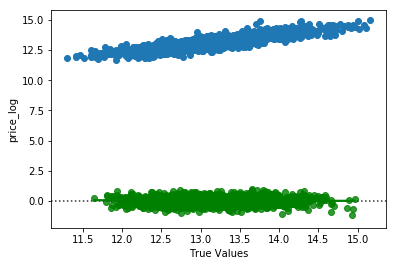

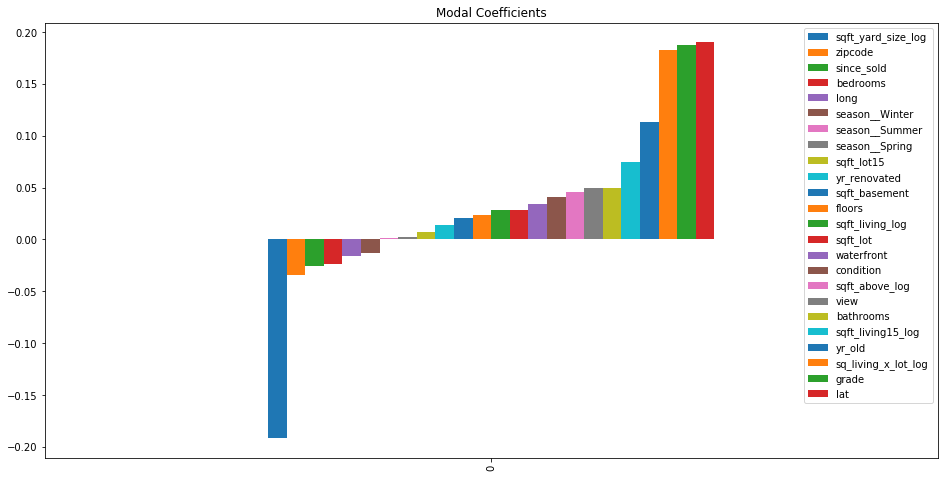

In [43]:
KC.evaluate_lm('Baseline')

### Remove Highly Correlated Features
##### Highly correlated ( corr > 0.95):
* `['sqft_lot', 'waterfront', 'condition', 'sqft_basement', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'yr_old', 'since_sold', 'sqft_yard_size_log', 'season__Spring', 'season__Summer', 'season__Winter']`

##### F-Test
* `'season__Spring', 'season__Summer'`

##### RFECV @ cv=20:
* `sqft_lot15'` (but redundant)

In [44]:
drop_list = []
KC.get_drop_list_corrs()
for feature in KC.get_drop_list_f_test():
    drop_list.append(feature)
    
for feature in KC.get_drop_list_rfecv():
    drop_list.append(feature)

reduced_features = []
for feature in feature_columns:
    if feature not in drop_list:
        reduced_features.append(feature)
        
print(feature_columns)
print(reduced_features)


['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15', 'yr_old', 'since_sold', 'sqft_living_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_yard_size_log', 'sq_living_x_lot_log', 'season__Spring', 'season__Summer', 'season__Winter']
['bedrooms', 'bathrooms', 'floors', 'view', 'grade', 'lat', 'sqft_living_log', 'sqft_above_log', 'sqft_living15_log', 'sq_living_x_lot_log']


## Run Linear Regression Model on Updated Feature Data


Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015666
Training Coefficients:
[-0.0156344   0.0111528  -0.00363021  0.08457192  0.1639522   0.20520546
  0.18120553 -0.01202953  0.05565388 -0.01279845]
Training R^2 Score: 0.7245037616712813
****
TRAINING ERRORS
Mean Absolute Error: 0.2133012247154025
Mean Squared Error: 0.07566726633049381
Root Mean Squared Error: 0.2750768371391779

By Deviation of Target

Mean Absolute Error (Z): 0.40731322992487157
Root Mean Squared Error (Z): 0.5252779732613783


/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


****
TESTING ERRORS
Test R^2 Score: 0.7294281116836252
Mean Absolute Error:0.21001090965817543
Mean Squared Error:0.07372571438118326
Root Mean Squared Error:0.2715247951498781

By Deviation of Target

Mean Absolute Error (Z): 0.4010301490132746
Root Mean Squared Error (Z): 0.518495106930344

***
RMSE
Training:  0.2750768371391779 vs. Testing:  0.2715247951498781


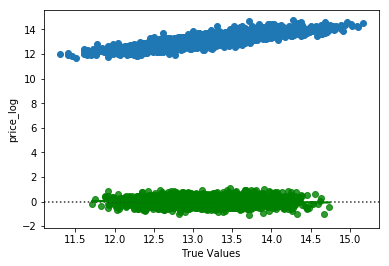

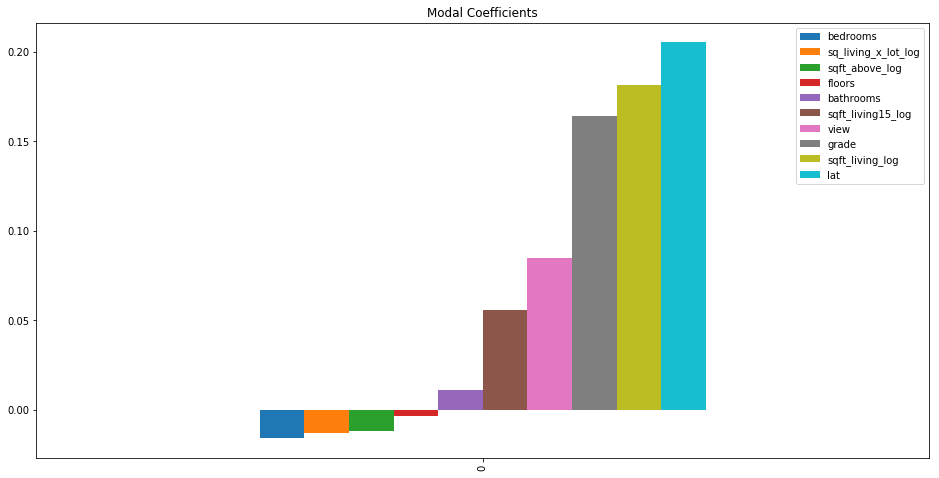

In [45]:
KC.set_target_and_features('price_log', reduced_features)
KC.split_data()
KC.evaluate_lm('Remove Corr')

## Evaluate Polynomials

In [47]:
degree = 3
KC.set_polynomial(degree)
KC.evaluate_lm()

KeyboardInterrupt: 

In [ ]:
KC.evaluate_ridge(1.0)

In [ ]:
KC.set_target_and_features('price_log', reduced_features)
KC.split_data()
KC.evaluate_lm()

Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.04738925101566
Training Coefficients:
[0.01488433 0.02773081 0.01464721 0.02313925 0.04136775 0.03816874
 0.03634741 0.02860344 0.03309227 0.01656581]
Training R^2 Score: 0.43232972475616277
****
TRAINING ERRORS
Mean Absolute Error: 0.31460197321005323
Mean Squared Error: 0.1559152247063638
Root Mean Squared Error: 0.39486101948199925

By Deviation of Target

Mean Absolute Error (Z): 0.6007539151258872
Root Mean Squared Error (Z): 0.7540140354619682
****
TESTING ERRORS
Test R^2 Score: 0.43284682872513924
Mean Absolute Error:0.31233029721630684
Mean Squared Error:0.15453849613120418
Root Mean Squared Error:0.3931138462725578

By Deviation of Target

Mean Absolute Error (Z): 0.5964159949494315
Root Mean Squared Error (Z): 0.7506776891089395

***
RMSE
Training:  0.39486101948199925 vs. Testing:  0.3931138462725578


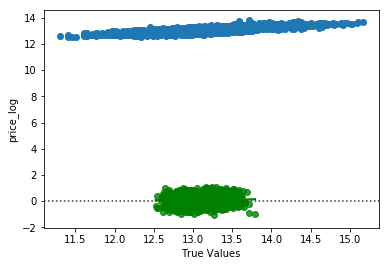

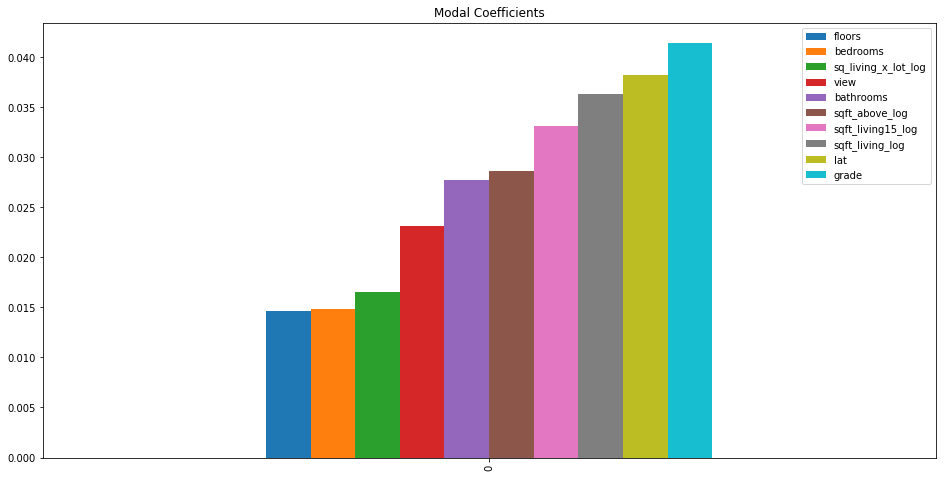

In [28]:
KC.evaluate_ridge(5.0)

In [29]:
# print(KC.history)

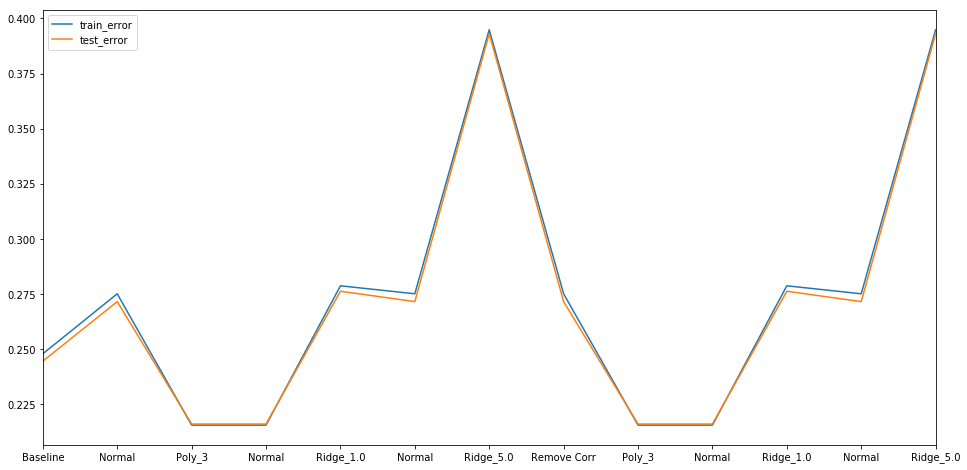

In [30]:
KC.plot_rmse_history()
plt.show()


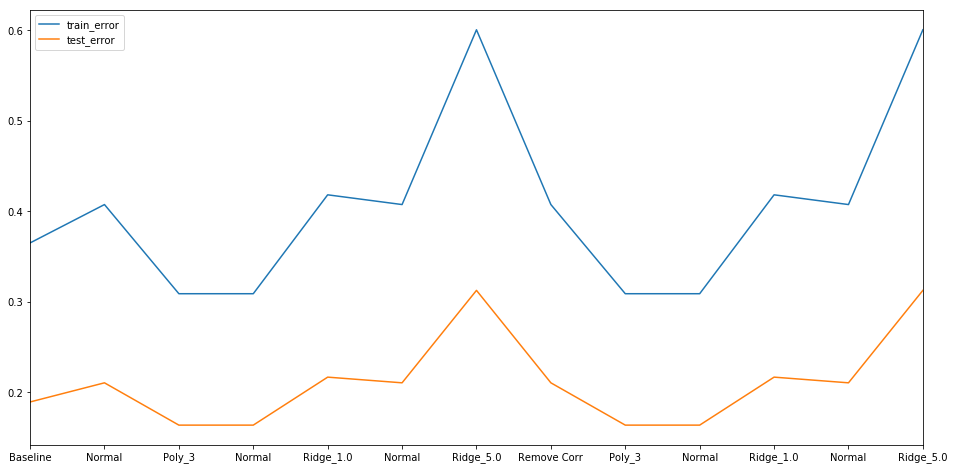

In [31]:
KC.plot_mae_history()


## Final Results:

In [32]:
KC.find_highest()

{'Training': {'result_type': 'Training Evaluation',
  'Training Intercept': 13.04738926855521,
  'Training Coefficients': array([ 8.43573389e-07,  6.12588972e+02, -4.43725913e+02,  9.26813891e+02,
         -1.04696864e+03, -1.84525207e+03, -3.52302737e+04,  1.18226938e+02,
         -6.85831579e+02, -1.70491494e+02,  6.51877185e+02, -9.96609139e+00,
          1.82905050e+00, -2.62962306e+01, -6.69427361e+00, -2.89079955e+01,
         -1.22537940e+03,  4.22901738e+01,  1.29569646e+01,  2.00483813e+01,
         -2.78397815e+01, -1.52066630e+01,  3.95390655e+01,  1.84576782e+00,
         -4.93169972e+00,  9.20736369e+02,  6.79887054e+00, -7.82701331e+01,
          4.36647270e+01, -9.35967049e+00,  4.54099239e+01,  8.01032807e-01,
         -5.02918332e+01, -1.87113704e+03, -2.76692326e+02,  1.28169178e+02,
          1.67527489e+02, -6.49326348e+00,  2.03139717e+00,  3.79598737e-01,
          2.16283723e+03, -3.41736435e+01, -5.25992237e+01,  1.30456898e+01,
          4.28925159e+00,  1.4983

In [33]:
KC.find_lowest()

TypeError: find_lowest() missing 1 required positional argument: 'category'